In [1]:
%matplotlib inline


Training a Classifier

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
import numpy as np


train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(size=(128,128)),
     transforms.RandomRotation([-30, 30]),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.4),
     transforms.RandomGrayscale(p=0.3),
     transforms.Normalize([0.485, 0.456, 0.406], 
                          [0.229, 0.224, 0.225])])
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(size=(128,128)),
     transforms.Normalize([0.485, 0.456, 0.406], 
                          [0.229, 0.224, 0.225])])

trainset1 = torchvision.datasets.Flowers102(root='./flowers102_data', split='test',
                                        download=True, transform=train_transform)
trainset2 = torchvision.datasets.Flowers102(root='./flowers102_data', split='val',
                                        download=True, transform=train_transform)
trainset3 = torchvision.datasets.Flowers102(root='./flowers102_data', split='test',
                                        download=True, transform=transform)


train_set = torch.utils.data.ConcatDataset([trainset1, trainset2, trainset3])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                          shuffle=True, num_workers=2)
                                       
print("Trainset size: ",len(train_set))

testset = torchvision.datasets.Flowers102(root='./flowers102_data', split='train',
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

print("Test size: ",len(testset))
classes = np.arange(0,102,1,dtype=int)

Trainset size:  13318
Test size:  1020


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


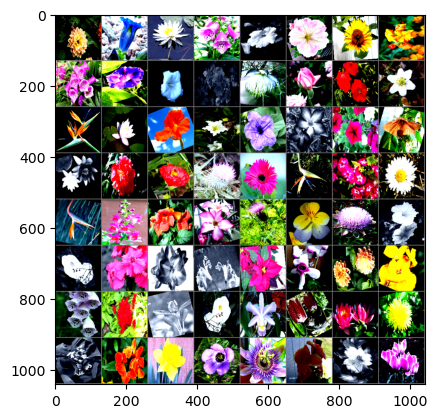

In [4]:
import matplotlib.pyplot as plt

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))

## Using GPU to Training

In [5]:
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))
torch.cuda.empty_cache()


device 0 NVIDIA GeForce RTX 3080


Define a Network



In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

ActF_List = [F.relu, F.leaky_relu, F.elu]
ActF_List_nn = [nn.ReLU, nn.LeakyReLU, nn.ELU]
global act_Func_id
act_Func_id = 0  

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            ActF_List_nn[act_Func_id](inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = ActF_List[act_Func_id](out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=102):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            ActF_List_nn[act_Func_id](),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.AvgPool = nn.AvgPool2d(4)
        self.fc1 = nn.Linear(512*8*8 , 512)
        self.fc2 = nn.Linear(512 , num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.AvgPool(out)
        
        out = torch.flatten(out,1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


def ResNet16():
    return ResNet(ResidualBlock)

net = ResNet16().to(device)
summary(net, (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,728
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,864
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]          36,864
       BatchNorm2d-8         [-1, 64, 128, 128]             128
     ResidualBlock-9         [-1, 64, 128, 128]               0
           Conv2d-10         [-1, 64, 128, 128]          36,864
      BatchNorm2d-11         [-1, 64, 128, 128]             128
             ReLU-12         [-1, 64, 128, 128]               0
           Conv2d-13         [-1, 64, 128, 128]          36,864
      BatchNorm2d-14         [-1, 64, 1

3.Define a Loss function and optimizer


In [10]:
def model_EvalAcc():
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()
    print('\nAccuracy of the network on the test images: %.2f %%' % (
        100 * correct / total))
    return correct / total

In [11]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.RAdam(net.parameters(), lr=1e-3, weight_decay=0.01)

4. Train the network


In [12]:
import time

# n_iters = 10000
# Epochs = n_iters / (len(trainset) / 100)
Epochs = 100
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()
        torch.cuda.empty_cache()
           
def model_fit(idx):
  
  global act_Func_id 
  act_Func_id = idx
  net.apply(weight_reset) 
  
  All_LossPerEpoch = np.empty(len(trainloader))
  Loss_History = np.empty(Epochs)
  
  print(f"Training use {str(ActF_List[idx])}\n")
  
  start_time = time.time()
  for epoch in range(Epochs):  # loop over the dataset multiple times
    running_loss = 0.0
      
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        All_LossPerEpoch[i] = loss.item()
        # print statistics
        if i == 0:
          print( f"\nEpoch:{epoch+1}" )
        if i == (len(trainloader) - 1):
          print(f"\r\tBatch:{i+1:03} of {len(trainloader)}, loss:{loss.item():.3f}", end="" ,flush=True)
        Loss_History[epoch] = np.mean(All_LossPerEpoch)

    _ = model_EvalAcc()
  Train_time = time.time() - start_time
  Accuracy = model_EvalAcc()
  print(f"\nFinished Training ,time cost: {Train_time}", end="\n")
  return Loss_History, (Train_time/60.0), Accuracy*100.0


Compare three activate_func



In [13]:
Compare_Items = ['Loss', 'TrainTime', 'Accuracy']
Loss_Compare = [[None] * Epochs] * 3
TrainTime_Compare = [None] * 3
Accuracy_Compare = [None] * 3
DifferenceDict = {'Loss': Loss_Compare,
                    'TrainTime': TrainTime_Compare,
                    'Accuracy': Accuracy_Compare}
model_list = ['./flowers102_model/relu_model.pt', './flowers102_model/leakyRelu_model.pt', './flowers102_model/Elu_model.pt']
 
for act_func in ActF_List:
    actF_idx = ActF_List.index(act_func)
    Loss_Compare[actF_idx], TrainTime_Compare[actF_idx], Accuracy_Compare[actF_idx] = model_fit(actF_idx)
    FILE = model_list[actF_idx]
    torch.save(net, FILE)     

Training use <function relu at 0x7f2030893830>


Epoch:1
	Batch:209 of 209, loss:3.327
Accuracy of the network on the test images: 20.00 %

Epoch:2
	Batch:209 of 209, loss:2.535
Accuracy of the network on the test images: 29.80 %

Epoch:3
	Batch:209 of 209, loss:2.015
Accuracy of the network on the test images: 34.90 %

Epoch:4
	Batch:209 of 209, loss:2.158
Accuracy of the network on the test images: 33.82 %

Epoch:5
	Batch:209 of 209, loss:3.212
Accuracy of the network on the test images: 32.65 %

Epoch:6
	Batch:209 of 209, loss:1.600
Accuracy of the network on the test images: 37.94 %

Epoch:7
	Batch:209 of 209, loss:1.524
Accuracy of the network on the test images: 39.31 %

Epoch:8
	Batch:209 of 209, loss:1.952
Accuracy of the network on the test images: 41.08 %

Epoch:9
	Batch:209 of 209, loss:1.479
Accuracy of the network on the test images: 37.45 %

Epoch:10
	Batch:209 of 209, loss:2.632
Accuracy of the network on the test images: 42.16 %

Epoch:11
	Batch:209 of 209, loss:2.412
A

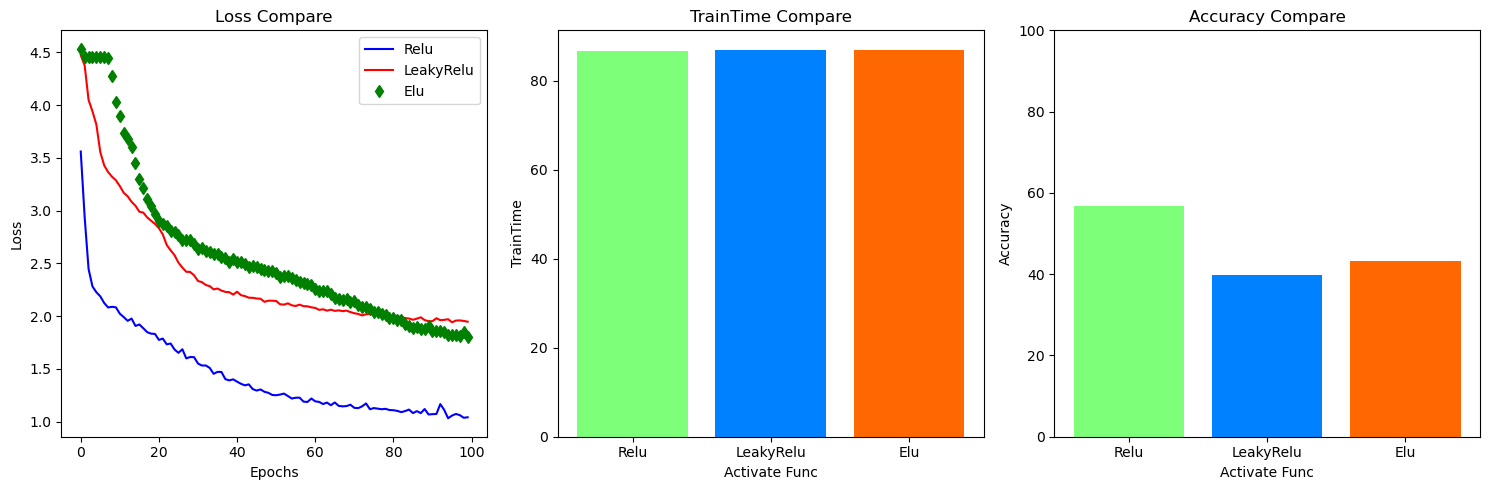

In [14]:
fig, ((LossFig, TrainTimeFig, AccFig)) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ActF_category = ['Relu', 'LeakyRelu', 'Elu']    

LossFig.plot(DifferenceDict['Loss'][0], 'b')
LossFig.plot(DifferenceDict['Loss'][1], 'r')
LossFig.plot(DifferenceDict['Loss'][2], 'gd')
LossFig.legend(['Relu','LeakyRelu','Elu'])
LossFig.set_title('Loss Compare')
LossFig.set_xlabel('Epochs')
LossFig.set_ylabel('Loss')

cmap = plt.get_cmap('jet')
color = [cmap(0.5), cmap(0.25), cmap(0.8)]
x = np.arange(1,4,dtype=int)

TrainTimeFig.bar(ActF_category, DifferenceDict['TrainTime'], color=color)
TrainTimeFig.set_title("TrainTime Compare")
TrainTimeFig.set_xlabel("Activate Func")
TrainTimeFig.set_ylabel("TrainTime")

AccFig.bar(ActF_category, DifferenceDict['Accuracy'], color=color) 
AccFig.set_ylim([0,100])
AccFig.set_title("Accuracy Compare")
AccFig.set_xlabel("Activate Func")
AccFig.set_ylabel("Accuracy")

fig.tight_layout()
plt.show()


In [15]:
print('=======================Performance Compare=======================')
print('Activation Func\t\tTraining Time(m)\tAccuracy')
for i in range(3):
    print(ActF_category[i], DifferenceDict['TrainTime'][i], DifferenceDict['Accuracy'][i], sep='\t\t')

=======================Performance Compare=======================
Activation Func		Training Time(m)	Accuracy
Relu		86.65596153736115		56.86274509803921
LeakyRelu		86.87494571606318		39.705882352941174
Elu		86.98990831772487		43.13725490196079


In [16]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

def model_performance(FILE):
    model = torch.load(FILE)
    
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    preds = np.zeros((1))
    truth = np.zeros((1))
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs, 1)
            c = (predicted.cpu() == labels).squeeze()
            preds = np.concatenate([preds, predicted.cpu().numpy()], axis=0)
            truth = np.concatenate([truth, labels.numpy()], axis=0)
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    
    # Display the confusion matrix as a heatmap
    arr = confusion_matrix(truth, preds)
    df_cm = pd.DataFrame(arr, classes, classes)
    plt.figure(figsize = (9,6))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("prediction")
    plt.ylabel("label (ground truth)")

In [17]:
# model_performance(model_list[0])

In [18]:
# model_performance(model_list[1])

In [19]:
# model_performance(model_list[2])